# Previsao de Demanda de Transporte Publico (Malasia)

Pipeline completo (limpeza → janelas → treino → avaliacao → graficos), usando **PyTorch**.

**Objetivo:** prever a demanda do **dia seguinte** para dois alvos:
- `bus_total` (onibus)
- `rail_total` (trens/metropolitano/rail)

> Nota: o dataset e diario, mas algumas colunas comecam em datas diferentes. Vamos tratar isso como **missing estrutural** (nao imputar antes do servico existir/ser reportado).


In [17]:
# (Opcional) Instale dependencias
# %pip -q install pandas numpy scikit-learn torch matplotlib statsmodels


## 0) Configuracao e imports

In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reprodutibilidade (melhor esforco; em GPU pode haver nao-determinismo)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cuda


## 1) Carregar dados

Duas opcoes:
- Ler o CSV local (se voce ja baixou)
- Baixar direto do data.gov.my


In [19]:
URL = "https://storage.data.gov.my/transportation/ridership_headline.csv"
LOCAL_PATH = "/mnt/data/ridership_headline.csv"  # ajuste se necessario

if os.path.exists(LOCAL_PATH):
    df = pd.read_csv(LOCAL_PATH)
    print("Lido de:", LOCAL_PATH)
else:
    df = pd.read_csv(URL)
    print("Baixado de:", URL)

df.head()

Baixado de: https://storage.data.gov.my/transportation/ridership_headline.csv


,date,bus_rkl,bus_rkn,bus_rpn,rail_lrt_ampang,rail_mrt_kajang,rail_lrt_kj,rail_monorail,rail_mrt_pjy,rail_ets,rail_intercity,rail_komuter_utara,rail_tebrau,rail_komuter
0,2019-01-01,NaN,NaN,NaN,113357,114173,139634,35804,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,NaN,NaN,NaN,182715,169316,274224,31859,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,NaN,NaN,NaN,187904,175304,286469,31893,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,NaN,NaN,NaN,198420,187891,304755,34121,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,NaN,NaN,NaN,120773,112660,145036,29950,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Tipos e indice temporal

df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date").set_index("date")

# Garantir numerico
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("shape:", df.shape)
print("monotonic:", df.index.is_monotonic_increasing, "duplicates:", df.index.has_duplicates)
df.isna().mean().sort_values(ascending=False).head(10)

shape: (2557, 13)
monotonic: True duplicates: False


rail_komuter          0.669926
rail_tebrau           0.494720
rail_mrt_pjy          0.493547
bus_rkn               0.428627
bus_rkl               0.428627
bus_rpn               0.428627
rail_intercity        0.255377
rail_komuter_utara    0.255377
rail_ets              0.255377
rail_mrt_kajang       0.000000
dtype: float64

## 2) Limpeza: frequencia diaria, valores invalidos e imputacao segura

Regras:
- Reindex diario (garante datas completas)
- Valores negativos → NaN
- **Nao imputar antes do primeiro valor valido** de cada coluna
- Interpolar apenas buracos curtos (ate 7 dias)


In [21]:
# Reindex diario
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(full_idx)
df.index.name = "date"

# Negativos nao fazem sentido (contagem)
df[df < 0] = np.nan

# Data de inicio por coluna (missing estrutural)
starts = df.apply(lambda s: s.first_valid_index()).sort_values()
starts.head(15), starts.tail(10)

(rail_lrt_ampang      2019-01-01
 rail_mrt_kajang      2019-01-01
 rail_lrt_kj          2019-01-01
 rail_monorail        2019-01-01
 rail_ets             2020-10-15
 rail_intercity       2020-10-15
 rail_komuter_utara   2020-10-15
 bus_rkl              2022-01-01
 bus_rkn              2022-01-01
 bus_rpn              2022-01-01
 rail_mrt_pjy         2022-06-16
 rail_tebrau          2022-06-19
 rail_komuter         2023-09-10
 dtype: datetime64[ns],
 rail_monorail        2019-01-01
 rail_ets             2020-10-15
 rail_intercity       2020-10-15
 rail_komuter_utara   2020-10-15
 bus_rkl              2022-01-01
 bus_rkn              2022-01-01
 bus_rpn              2022-01-01
 rail_mrt_pjy         2022-06-16
 rail_tebrau          2022-06-19
 rail_komuter         2023-09-10
 dtype: datetime64[ns])

In [22]:
# Imputacao segura (somente apos o inicio de cada coluna)
df_clean = df.copy()

for col in df_clean.columns:
    start = df_clean[col].first_valid_index()
    if start is None:
        continue

    s_valid = df_clean.loc[start:, col]
    s_valid = s_valid.interpolate(method="time", limit=7)

    df_clean.loc[start:, col] = s_valid

missing_top = df_clean.isna().mean().sort_values(ascending=False).head(10)
missing_top

rail_komuter          0.669926
rail_tebrau           0.494720
rail_mrt_pjy          0.493547
bus_rkn               0.428627
bus_rkl               0.428627
bus_rpn               0.428627
rail_intercity        0.255377
rail_komuter_utara    0.255377
rail_ets              0.255377
rail_mrt_kajang       0.000000
dtype: float64

## 3) Construir alvos (multivariado): bus_total e rail_total

O dataset tem varias colunas `rail_*` e tres colunas de bus:
- `bus_rkl`, `bus_rkn`, `bus_rpn`

Vamos somar por modo.


In [23]:
bus_cols = ["bus_rkl", "bus_rkn", "bus_rpn"]
rail_cols = [c for c in df_clean.columns if c.startswith("rail_")]

df_model = pd.DataFrame(index=df_clean.index)
df_model["bus_total"] = df_clean[bus_cols].sum(axis=1, min_count=1)
df_model["rail_total"] = df_clean[rail_cols].sum(axis=1, min_count=1)

# Onibus so tem dados a partir de 2022-01-01 neste dump
START_DATE = "2022-01-01"
df_model = df_model.loc[START_DATE:].copy()

# Remove dias sem alvo (se houver)
df_model = df_model.dropna()

df_model.head(), df_model.isna().sum()

(            bus_total  rail_total
 date                             
 2022-01-01   113916.0    271928.0
 2022-01-02   103221.0    225843.0
 2022-01-03   142653.0    353129.0
 2022-01-04   141753.0    362964.0
 2022-01-05   144365.0    366186.0,
 bus_total     0
 rail_total    0
 dtype: int64)

## 4) Features de calendario

Essas features ajudam muito em transporte publico:
- dia da semana (0..6)
- fim de semana
- dia do ano

(Se voce tiver feriados, pode adicionar depois.)


In [24]:
df_mulvar = df_model.copy()   # contém bus_total e rail_total

# -----------------------------
# Calendário do dia ATUAL (t)
# -----------------------------
df_mulvar["dow"] = df_mulvar.index.dayofweek
df_mulvar["is_weekend"] = (df_mulvar["dow"] >= 5).astype(int)
df_mulvar["dayofyear"] = df_mulvar.index.dayofyear

# -----------------------------
# Calendário CONHECIDO DO FUTURO (t+1)
# -----------------------------
df_mulvar["next_dow"] = df_mulvar["dow"].shift(-1)
df_mulvar["next_is_weekend"] = df_mulvar["is_weekend"].shift(-1)

# One-hot do tipo do dia de amanhã
df_mulvar = pd.get_dummies(df_mulvar, columns=["next_dow"], dtype=float)

# Remove o último dia (não sabemos o tipo do dia seguinte)
df_mulvar = df_mulvar.dropna()

print("Shape df_mulvar:", df_mulvar.shape)
df_mulvar.head()


Shape df_mulvar: (1460, 13)


,bus_total,rail_total,dow,is_weekend,dayofyear,next_is_weekend,next_dow_0.0,next_dow_1.0,next_dow_2.0,next_dow_3.0,next_dow_4.0,next_dow_5.0,next_dow_6.0
date,,,,,,,,,,,,,
2022-01-01,113916.0,271928.0,5,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-02,103221.0,225843.0,6,1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03,142653.0,353129.0,0,0,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,141753.0,362964.0,1,0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-01-05,144365.0,366186.0,2,0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 5) Split temporal + normalizacao (sem vazamento)

- Separa treino/teste no tempo
- Ajusta scaler so no treino


In [25]:
split = int(len(df_mulvar) * 0.8)
train = df_mulvar.iloc[:split]
test = df_mulvar.iloc[split:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

feat_cols = train.columns.tolist()
target_cols = ["bus_total", "rail_total"]
target_idx = [feat_cols.index(c) for c in target_cols]

print("train_scaled:", train_scaled.shape)
print("test_scaled:", test_scaled.shape)
print("features:", feat_cols)
print("targets idx:", target_idx)

train_scaled: (1168, 13)
test_scaled: (292, 13)
features: ['bus_total', 'rail_total', 'dow', 'is_weekend', 'dayofyear', 'next_is_weekend', 'next_dow_0.0', 'next_dow_1.0', 'next_dow_2.0', 'next_dow_3.0', 'next_dow_4.0', 'next_dow_5.0', 'next_dow_6.0']
targets idx: [0, 1]


In [26]:
print("Features (inputs):")
for c in feat_cols:
    print(" -", c)

print("\nTargets:", target_cols)


Features (inputs):
 - bus_total
 - rail_total
 - dow
 - is_weekend
 - dayofyear
 - next_is_weekend
 - next_dow_0.0
 - next_dow_1.0
 - next_dow_2.0
 - next_dow_3.0
 - next_dow_4.0
 - next_dow_5.0
 - next_dow_6.0

Targets: ['bus_total', 'rail_total']


## 6) Dataset com janelas via __getitem__ (estilo profissional)

Cada amostra = (janela de W dias) → (alvo no dia seguinte).

Numero de janelas = N - W.


In [27]:
class WindowDataset(Dataset):
    def __init__(self, data: np.ndarray, window: int, target_idx: list[int]):
        self.window = int(window)
        self.target_idx = list(target_idx)

        # converte UMA vez
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data) - self.window

    def __getitem__(self, idx: int):
        X = self.data[idx: idx + self.window, :]
        y = self.data[idx + self.window, self.target_idx]
        return X, y


WINDOW = 30  # ajuste aqui

# para manter contexto no teste, concatenamos fim do treino + teste
all_scaled = np.vstack([train_scaled, test_scaled])
cut = len(train_scaled)  # ponto onde comeca o teste em termos de observacoes

# dataset completo (para pegar janelas do teste com contexto)
full_dataset = WindowDataset(all_scaled, window=WINDOW, target_idx=target_idx)

# indices de janelas que pertencem ao treino e ao teste
# janelas de treino: aquelas cujo alvo (idx+WINDOW) < cut
train_len = cut - WINDOW

print("N observacoes (train+test):", len(all_scaled))
print("WINDOW:", WINDOW)
print("Total de janelas:", len(full_dataset))
print("Janelas de treino:", train_len)
print("Janelas de teste:", len(full_dataset) - train_len)

# sanity check
X0, y0 = full_dataset[0]
print("X0:", X0.shape, "y0:", y0.shape)

N observacoes (train+test): 1460
WINDOW: 30
Total de janelas: 1430
Janelas de treino: 1138
Janelas de teste: 292
X0: torch.Size([30, 13]) y0: torch.Size([2])


## 7) DataLoader (batches) e (opcional) embaralhamento

- `shuffle=True` **somente no treino** pode ajudar o otimizador (aproxima i.i.d.).
- Em serie temporal, mantenha `shuffle=False` no teste.

Aqui deixamos um switch.


In [28]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True  # mude para False se preferir conservador

# Sub-datasets por indices
class SubsetDataset(Dataset):
    def __init__(self, base: Dataset, start: int, end: int):
        self.base = base
        self.start = start
        self.end = end
    def __len__(self):
        return self.end - self.start
    def __getitem__(self, idx):
        return self.base[self.start + idx]

train_ds = SubsetDataset(full_dataset, 0, train_len)
test_ds = SubsetDataset(full_dataset, train_len, len(full_dataset))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([32, 30, 13]), torch.Size([32, 2]))

## 8) Modelos: RNN e GRU

Comece com RNN (baseline deep) e depois troque para GRU.


In [29]:
class RNNModel(nn.Module):
    def __init__(self, n_features: int, hidden: int = 50, out: int = 2, kind: str = "gru"):
        super().__init__()
        kind = kind.lower()
        if kind == "rnn":
            self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden, batch_first=True, nonlinearity="tanh")
        elif kind == "gru":
            self.rnn = nn.GRU(input_size=n_features, hidden_size=hidden, batch_first=True)
        else:
            raise ValueError("kind must be 'rnn' or 'gru'")
        self.fc = nn.Linear(hidden, out)

    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last)

N_FEATURES = len(feat_cols)
HIDDEN = 50
KIND = "gru"  # 'rnn' ou 'gru'

model = RNNModel(n_features=N_FEATURES, hidden=HIDDEN, out=2, kind=KIND).to(DEVICE)
print(model)

RNNModel(
  (rnn): GRU(13, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)


## 9) Treinamento com validacao + early stopping

- Separa um pedaco do treino para validacao
- Para quando `val_loss` nao melhora por algumas epocas


In [30]:
from copy import deepcopy

def split_train_val(dataset: Dataset, val_frac: float = 0.1):
    n = len(dataset)
    n_val = int(n * val_frac)
    n_train = n - n_val
    train_part = SubsetDataset(dataset, 0, n_train)
    val_part = SubsetDataset(dataset, n_train, n)
    return train_part, val_part

train_part, val_part = split_train_val(train_ds, val_frac=0.1)
train_part_loader = DataLoader(train_part, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN)
val_loader = DataLoader(val_part, batch_size=BATCH_SIZE, shuffle=False)

def evaluate_loader(model, loader, loss_fn):
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total += loss.item() * len(xb)
            n += len(xb)
    return total / max(n, 1)

def train_model(model, train_loader, val_loader, epochs=50, lr=3e-4, patience=8):
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best = float("inf")
    best_state = None
    bad = 0

    history = {"train": [], "val": []}

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        n = 0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item() * len(xb)
            n += len(xb)

        train_loss = total / max(n, 1)
        val_loss = evaluate_loader(model, val_loader, loss_fn)
        history["train"].append(train_loss)
        history["val"].append(val_loss)

        print(f"epoch {ep:03d} train {train_loss:.6f} | val {val_loss:.6f}")

        if val_loss < best - 1e-6:
            best = val_loss
            best_state = deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history

history = train_model(model, train_part_loader, val_loader, epochs=80, lr=3e-4, patience=10)


epoch 001 train 0.171272 | val 0.197397
epoch 002 train 0.049636 | val 0.041423
epoch 003 train 0.033809 | val 0.049269
epoch 004 train 0.028395 | val 0.041577
epoch 005 train 0.024547 | val 0.034360
epoch 006 train 0.021024 | val 0.030722
epoch 007 train 0.017647 | val 0.024099
epoch 008 train 0.014305 | val 0.019625
epoch 009 train 0.011255 | val 0.013418
epoch 010 train 0.008187 | val 0.011033
epoch 011 train 0.006621 | val 0.010716
epoch 012 train 0.006216 | val 0.009862
epoch 013 train 0.006096 | val 0.009654
epoch 014 train 0.006139 | val 0.009576
epoch 015 train 0.006190 | val 0.009114
epoch 016 train 0.005914 | val 0.009036
epoch 017 train 0.005841 | val 0.008918
epoch 018 train 0.006001 | val 0.009479
epoch 019 train 0.005806 | val 0.009119
epoch 020 train 0.005813 | val 0.008768
epoch 021 train 0.005867 | val 0.009238
epoch 022 train 0.005789 | val 0.009096
epoch 023 train 0.006035 | val 0.009586
epoch 024 train 0.006260 | val 0.008915
epoch 025 train 0.005669 | val 0.008804


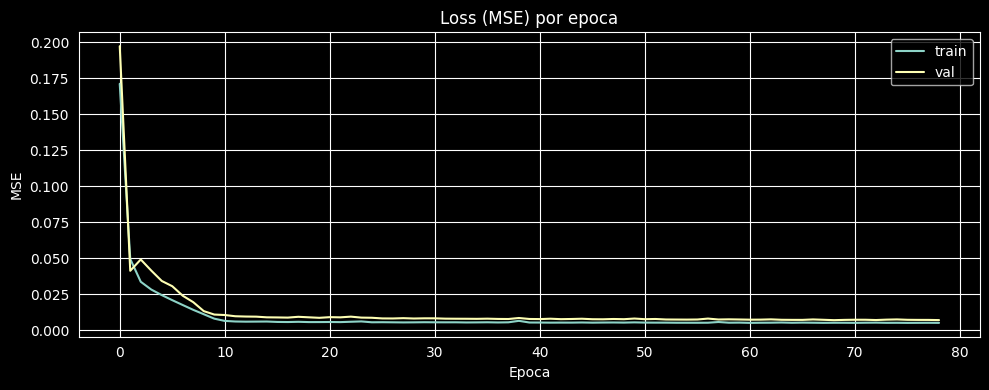

In [31]:
# Curva de loss
plt.figure(figsize=(10,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.title("Loss (MSE) por epoca")
plt.xlabel("Epoca")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

## 10) Avaliacao no teste + baseline + desnormalizacao

Metricas:
- MAE e RMSE (normalizado)
- MAE e RMSE (escala original)
- Baseline persistencia: amanha = hoje


In [32]:
def predict_loader(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.vstack(preds), np.vstack(trues)

pred_scaled, true_scaled = predict_loader(model, test_loader)

mae_norm = np.mean(np.abs(pred_scaled - true_scaled), axis=0)
rmse_norm = np.sqrt(np.mean((pred_scaled - true_scaled)**2, axis=0))
print("MAE norm [bus, rail]:", mae_norm)
print("RMSE norm [bus, rail]:", rmse_norm)

def inverse_targets(y_scaled: np.ndarray, scaler: MinMaxScaler, n_features: int, target_idx: list[int]):
    tmp = np.zeros((len(y_scaled), n_features), dtype=np.float32)
    tmp[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(tmp)
    return inv[:, target_idx]

n_features = len(feat_cols)
pred_orig = inverse_targets(pred_scaled, scaler, n_features, target_idx)
true_orig = inverse_targets(true_scaled, scaler, n_features, target_idx)

mae_orig = np.mean(np.abs(pred_orig - true_orig), axis=0)
rmse_orig = np.sqrt(np.mean((pred_orig - true_orig)**2, axis=0))
print("MAE original [bus, rail]:", mae_orig)
print("RMSE original [bus, rail]:", rmse_orig)

# Baseline persistencia: usa ultimo passo da janela
# Para obter baseline no teste, precisamos reconstruir X do teste
# Como o test_ds e um subset do full_dataset, podemos amostrar X de cada item.
X_test = np.stack([test_ds[i][0].numpy() for i in range(len(test_ds))], axis=0)
baseline_pred_scaled = X_test[:, -1, :][:, target_idx]

mae_b = np.mean(np.abs(baseline_pred_scaled - true_scaled), axis=0)
rmse_b = np.sqrt(np.mean((baseline_pred_scaled - true_scaled)**2, axis=0))
print("Baseline MAE norm:", mae_b)
print("Baseline RMSE norm:", rmse_b)

baseline_orig = inverse_targets(baseline_pred_scaled, scaler, n_features, target_idx)
mae_b_orig = np.mean(np.abs(baseline_orig - true_orig), axis=0)
rmse_b_orig = np.sqrt(np.mean((baseline_orig - true_orig)**2, axis=0))
print("Baseline MAE original:", mae_b_orig)
print("Baseline RMSE original:", rmse_b_orig)

MAE norm [bus, rail]: [0.07114768 0.05825866]
RMSE norm [bus, rail]: [0.11278258 0.0833084 ]
MAE original [bus, rail]: [15296.757 67720.25 ]
RMSE original [bus, rail]: [24248.254 96838.27 ]
Baseline MAE norm: [0.1442931  0.12239636]
Baseline RMSE norm: [0.22307646 0.1848245 ]
Baseline MAE original: [ 31023.018 142274.4  ]
Baseline RMSE original: [ 47961.438 214841.31 ]


## 11) Grafico real vs previsto (Deep Learning)

Alinhamento do indice:
- Cada previsao do teste corresponde ao **alvo** (dia t+1) das janelas do `test_ds`.
- Portanto, usamos o final do indice de `df_feat` com o mesmo comprimento de `true_orig`.


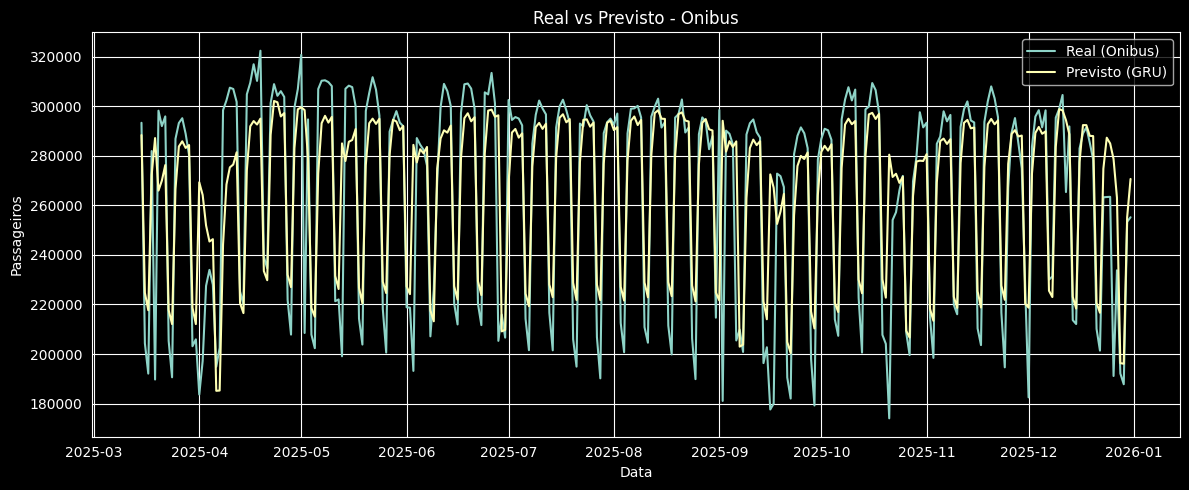

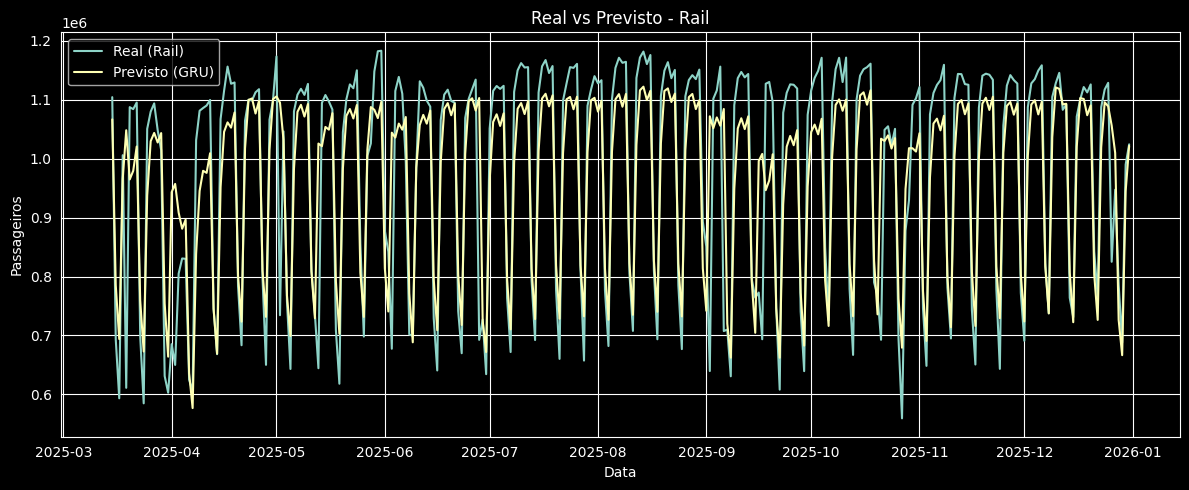

In [33]:
n = len(true_orig)
idx = df_feat.index[-n:]

plt.figure(figsize=(12,5))
plt.plot(idx, true_orig[:,0], label="Real (Onibus)")
plt.plot(idx, pred_orig[:,0], label=f"Previsto ({KIND.upper()})")
plt.title("Real vs Previsto - Onibus")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(idx, true_orig[:,1], label="Real (Rail)")
plt.plot(idx, pred_orig[:,1], label=f"Previsto ({KIND.upper()})")
plt.title("Real vs Previsto - Rail")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()

## 12) Estacionariedade + SARIMA (classico)

SARIMA e univariado. Abaixo fazemos para `bus_total` (repita para `rail_total` se quiser).

Passos:
1. Teste ADF (na serie original)
2. Ajuste SARIMA e previsao no periodo de teste
3. Grafico real vs previsto


ADF statistic: -2.1106071202646146
ADF p-value: 0.24027087158888555
SARIMA MAE: 35470.371895346056
SARIMA RMSE: 45569.8375686455


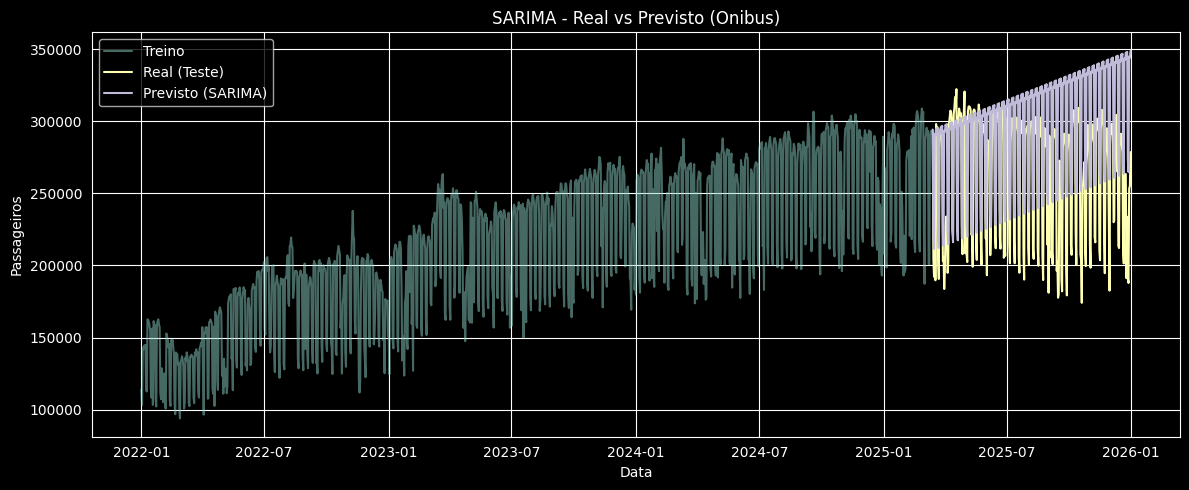

In [34]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_model["bus_total"].copy()

adf = adfuller(y.dropna())
print("ADF statistic:", adf[0])
print("ADF p-value:", adf[1])

# Split temporal igual ao deep
split_y = int(len(y) * 0.8)
y_train = y.iloc[:split_y]
y_test = y.iloc[split_y:]

sarima = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res = sarima.fit(disp=False)

y_pred = res.forecast(steps=len(y_test))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Treino", alpha=0.5)
plt.plot(y_test.index, y_test, label="Real (Teste)")
plt.plot(y_test.index, y_pred, label="Previsto (SARIMA)")
plt.title("SARIMA - Real vs Previsto (Onibus)")
plt.xlabel("Data")
plt.ylabel("Passageiros")
plt.legend()
plt.tight_layout()
plt.show()

## 13) Notas finais e proximos passos

- Se a GRU nao superar a RNN simples, isso pode ser normal: depende de janela, dados e hiperparametros.
- Para melhorar:
  - testar `WINDOW=28` ou `WINDOW=56`
  - testar `HIDDEN=32` ou `HIDDEN=64`
  - usar features de feriados (Malasia)
  - avaliar separadamente periodos atipicos


In [35]:
import numpy as np
import pandas as pd
import torch

def make_row_for_date(date: pd.Timestamp, feat_cols: list[str]) -> pd.Series:
    """
    Cria UMA linha (em escala original, não normalizada) com todas as features de calendário,
    incluindo as 'conhecidas do futuro' (next_*), no mesmo formato do df_mulvar.
    bus_total e rail_total ficam como NaN aqui e serão preenchidos depois.
    """
    dow = int(date.dayofweek)
    is_weekend = int(dow >= 5)
    dayofyear = int(date.dayofyear)

    next_date = date + pd.Timedelta(days=1)
    next_dow = int(next_date.dayofweek)
    next_is_weekend = int(next_dow >= 5)

    row = pd.Series(index=feat_cols, dtype=float)

    # alvos (vão ser preenchidos)
    row["bus_total"] = np.nan
    row["rail_total"] = np.nan

    # calendário do dia t
    if "dow" in row.index: row["dow"] = dow
    if "is_weekend" in row.index: row["is_weekend"] = is_weekend
    if "dayofyear" in row.index: row["dayofyear"] = dayofyear

    # calendário conhecido do futuro (t+1)
    if "next_is_weekend" in row.index: row["next_is_weekend"] = next_is_weekend

    # one-hot de next_dow (colunas tipo next_dow_0 ... next_dow_6)
    for k in range(7):
        col = f"next_dow_{k}"
        if col in row.index:
            row[col] = 1.0 if k == next_dow else 0.0

    return row


In [36]:
def forecast_14_days_recursive(
    model,
    df_mulvar: pd.DataFrame,
    feat_cols: list[str],
    target_idx: list[int],
    scaler,
    window: int = 30,
    n_steps: int = 14,
    device: str = "cpu",
):
    """
    Retorna um DataFrame com previsões para os próximos n_steps dias
    (bus_total e rail_total), usando a estratégia do livro: prever 1 passo,
    anexar na entrada e repetir. :contentReference[oaicite:2]{index=2}
    """
    model.eval()

    # Última janela conhecida EM ESCALA ORIGINAL (DataFrame)
    history_orig = df_mulvar[feat_cols].iloc[-window:].copy()
    last_date = df_mulvar.index[-1]

    preds = []

    with torch.no_grad():
        for step in range(1, n_steps + 1):
            next_date = last_date + pd.Timedelta(days=step)

            # 1) Normaliza a janela atual e prevê 1 passo
            X_scaled = scaler.transform(history_orig.values)  # (window, n_features)
            X = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0).to(device)  # (1, window, n_features)

            y_pred_scaled = model(X).cpu().numpy()[0]  # (2,)

            # 2) Desnormaliza SOMENTE os alvos (bus, rail)
            tmp = np.zeros((1, len(feat_cols)), dtype=np.float32)
            tmp[:, target_idx] = y_pred_scaled
            y_pred_orig = scaler.inverse_transform(tmp)[0, target_idx]  # (2,)

            # 3) Monta a próxima linha (features do dia futuro + alvos previstos)
            row = make_row_for_date(next_date, feat_cols)
            row.iloc[target_idx[0]] = y_pred_orig[0]  # bus_total
            row.iloc[target_idx[1]] = y_pred_orig[1]  # rail_total

            preds.append((next_date, y_pred_orig[0], y_pred_orig[1]))

            # 4) Atualiza a janela: drop a primeira linha, append a nova
            history_orig = pd.concat([history_orig.iloc[1:], row.to_frame().T], axis=0)

    pred_df = pd.DataFrame(preds, columns=["date", "bus_total_pred", "rail_total_pred"]).set_index("date")
    return pred_df


In [ ]:
pred_14 = forecast_14_days_recursive(
    model=model,
    df_mulvar=df_mulvar,
    feat_cols=feat_cols,
    target_idx=target_idx,
    scaler=scaler,
    window=WINDOW,
    n_steps=14,
    device=DEVICE,
)

pred_14
